Name: Kelley Monzella

Date: 2/27/2021

Description: Write python wrapper to call R script of Bill Petti's data

## KM: Running R script in R via Python

In [ ]:
### Step 1: Load R script (including libraries and functions)

In [10]:
# this should source the R code and read in the main function, f. This function takes a single parameter, the gamepk ID
# we call this function in the step below
# Note that the R script 00_statcast_api_scraping_single.R is saved in the same folder as this jupyter notebook 

import subprocess
subprocess.check_call(['Rscript', '00_statcast_api_scraping_single.R'], shell=False)

In [ ]:
### Step 2: Call function in python

In [ ]:
# in this section of code, the user should update the gids parameter (below), which is the input to the function f
# this then runs f and then saves the datafile.?
# HOWEVER -- this has not been tested! I am not sure if you can actually call R code in python (perhaps by updating this cell type)
# although I know you can source code, like I have done above.

gids  [INSERT GAME ID HERE]
dat <- f(gids)
saveRDS(dat, file = "statcastsingle.rds", compress=FALSE)
  
  
  
  
  
  

## NC: Running R script in embedded R environment in Python via rpy2 package

Elminates need for R program to also be running

#### Install if needed. Else just import

In [6]:
import numpy as np

# !pip install rpy2
# documentation: https://rpy2.github.io/doc/v2.9.x/html/introduction.html
import rpy2

In [7]:
import rpy2.robjects as robjects

#### Import base packages

In [8]:
from rpy2.robjects.packages import importr
# import R's "base" package
base = importr('base')

# import R's "utils" package
utils = importr('utils')

In [9]:
# import rpy2's package module
import rpy2.robjects.packages as rpackages

# import R's utility package
utils = rpackages.importr('utils')

# select a mirror for R packages
utils.chooseCRANmirror(ind=1) # select the first mirror in the list

rpy2.rinterface.NULL

#### Install additional packages

In [16]:
# R package names
packnames = ('magrittr', 'dplyr','jsonlite', 'tidyverse', 'mlbgameday','baseballr','DBI','RPostgreSQL')

# R vector of strings
from rpy2.robjects.vectors import StrVector

# Selectively install what needs to be install.
# We are fancy, just because we can.
names_to_install = [x for x in packnames if not rpackages.isinstalled(x)]
if len(names_to_install) > 0:
    utils.install_packages(StrVector(names_to_install))

#### Test some R scripts

In [22]:
# Calling value for Pi. Note it comes as a FloatVector
pi = robjects.r('pi')
pi

3.141593


In [23]:
# It can easily be transformed as needed
piArray = np.array(pi)
piInt = piArray.astype(int)

print(piArray)
print(piInt)

[3.14159265]
[3]


#### Using an R function

In [24]:
robjects.r('''
        # initialize dataframe of results
        stats_api_live_empty_df <- data.frame(NULL)
        
        # --- call API
          f <- function (game_pk){

            # call API
            api_call <- paste0("http://statsapi.mlb.com/api/v1.1/game/", game_pk, "/feed/live")

            # load data
            payload <- jsonlite::fromJSON(api_call, flatten = TRUE)
            print(head(payload))

            print(message(paste("Current game_pk is: ", game_pk)))

            # pull features from payload data - live data
            plays         <- payload$liveData$plays$allPlays$playEvents %>% bind_rows()
            at_bats       <- payload$liveData$plays$allPlays
            current       <- payload$liveData$plays$currentPlay

            # pull feature from payload data - game metadata
            game_status   <- payload$gameData$status$abstractGameState
            home_team     <- payload$gameData$teams$home$name
            home_level    <- payload$gameData$teams$home$sport
            home_league   <- payload$gameData$teams$home$league
            away_team     <- payload$gameData$teams$away$name
            away_level    <- payload$gameData$teams$away$sport
            away_league   <- payload$gameData$teams$away$league

            # need to look into what this is doing
            list_columns  <- lapply(at_bats, function(x) class(x)) %>% 
              dplyr::bind_rows(.id = "variable") %>% tidyr::gather(key, 
                                                                   value) %>% dplyr::filter(value == "list") %>% dplyr::pull(key)

            at_bats <- at_bats %>% dplyr::select(-c(one_of(list_columns)))

            # building pitch by pitch data

            pbp <- plays %>% dplyr::left_join(at_bats, by = c(endTime = "playEndTime"))

            # Fill missing values - why is this separate from mutates below? Assess run time differences
            pbp <- pbp %>% tidyr::fill(atBatIndex:matchup.splits.menOnBase, 
                                       .direction = "up") %>% 
              dplyr::mutate(game_pk = game_pk, 
                            game_date = substr(payload$gameData$datetime$dateTime, 1, 10)) %>% 
              dplyr::select(game_pk, game_date, everything())

            # Fill columns of data frame with values pulled in code above
            pbp <- pbp %>% dplyr::mutate(matchup.batter.fullName  = factor(matchup.batter.fullName), 
                                         matchup.pitcher.fullName = factor(matchup.pitcher.fullName), 
                                         atBatIndex               = factor(atBatIndex)) %>% 
              dplyr::mutate(home_team                = home_team, 
                            home_level_id            = home_level$id, 
                            home_level_name          = home_level$name, 
                            #home_parentOrg_id        = payload$gameData$teams$home$parentOrgId, 
                            #home_parentOrg_name      = payload$gameData$teams$home$parentOrgName, 
                            home_league_id           = home_league$id, 
                            home_league_name         = home_league$name, 
                            away_team                = away_team, 
                            away_level_id            = away_level$id, 
                            away_level_name          = away_level$name, 
                            #away_parentOrg_id        = payload$gameData$teams$away$parentOrgId, 
                            #away_parentOrg_name      = payload$gameData$teams$away$parentOrgName, 
                            away_league_id           = away_league$id, 
                            away_league_name         = away_league$name, 
                            batting_team             = factor(ifelse(about.halfInning == "bottom", home_team, away_team)), 
                            fielding_team            = factor(ifelse(about.halfInning == "bottom", away_team, home_team)))

            pbp <- pbp %>% dplyr::arrange(desc(atBatIndex), desc(pitchNumber))
            pbp <- pbp %>% dplyr::group_by(atBatIndex) %>% 
              dplyr::mutate(last.pitch.of.ab = ifelse(pitchNumber == max(pitchNumber), "true", "false"), 
                            last.pitch.of.ab = factor(last.pitch.of.ab)) %>% 
              ungroup()

            pbp <- dplyr::bind_rows(stats_api_live_empty_df, pbp)

            check_home_level <- pbp %>% dplyr::distinct(home_level_id) %>% dplyr::pull()

            pbp <- pbp %>% dplyr::rename(count.balls.start   = count.balls.x, 
                                         count.strikes.start = count.strikes.x, count.outs.start = count.outs.x, 
                                         count.balls.end     = count.balls.y, count.strikes.end = count.strikes.y, 
                                         count.outs.end      = count.outs.y)
            return(pbp)
          }
        ''')

R object with classes: ('function',) mapped to:
<SignatureTranslatedFunction - Python:0x0000025F61FEB908 / R:0x0000025F62276518>

In [25]:
# Bringing function into Python global environment
r_f = robjects.globalenv['f']
# >>> print(r_f.r_repr())

In [27]:
# Ran into an issue with it here... need to investigate
dat = r_f(642217)
type(dat)

RRuntimeError: Error in payload$liveData$plays$allPlays$playEvents %>% bind_rows() : 
  could not find function "%>%"


# Besides running into the error above when running, roblem with above method (possibly solvable) is that it returns output as FloatVector....

#### Trying an alternative version by just grabbing the data via API in Python

[Helpful article](https://towardsdatascience.com/how-to-convert-json-into-a-pandas-dataframe-100b2ae1e0d8) to learn about dealing with json files in Python

##### Was able to pull some data directly this way, which is likely more efficient. We'd just need to rewrite Bill's function for Python, which might be a challenge.... (yikes)

In [47]:
import json
# load data using Python JSON module
with urllib.request.urlopen("http://statsapi.mlb.com/api/v1/schedule/games/?sportId=1") as url:
    data = json.loads(url.read())
    
# Normalizing data
df = pd.json_normalize(data, record_path =['dates','games'])

In [49]:
df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
gamePk,642147,642040,642127,641640,641545,641562,641544,641636,641699,642084,641922,641563,642096,642217
link,/api/v1.1/game/642147/feed/live,/api/v1.1/game/642040/feed/live,/api/v1.1/game/642127/feed/live,/api/v1.1/game/641640/feed/live,/api/v1.1/game/641545/feed/live,/api/v1.1/game/641562/feed/live,/api/v1.1/game/641544/feed/live,/api/v1.1/game/641636/feed/live,/api/v1.1/game/641699/feed/live,/api/v1.1/game/642084/feed/live,/api/v1.1/game/641922/feed/live,/api/v1.1/game/641563/feed/live,/api/v1.1/game/642096/feed/live,/api/v1.1/game/642217/feed/live
gameType,S,S,S,S,S,S,S,S,S,S,S,S,S,S
season,2021,2021,2021,2021,2021,2021,2021,2021,2021,2021,2021,2021,2021,2021
gameDate,2021-03-28T17:05:00Z,2021-03-28T17:05:00Z,2021-03-28T17:05:00Z,2021-03-28T17:05:00Z,2021-03-28T17:05:00Z,2021-03-28T17:05:00Z,2021-03-28T17:07:00Z,2021-03-28T19:05:00Z,2021-03-28T19:10:00Z,2021-03-28T20:05:00Z,2021-03-28T20:05:00Z,2021-03-28T20:05:00Z,2021-03-28T20:10:00Z,2021-03-29T01:07:00Z
officialDate,2021-03-28,2021-03-28,2021-03-28,2021-03-28,2021-03-28,2021-03-28,2021-03-28,2021-03-28,2021-03-28,2021-03-28,2021-03-28,2021-03-28,2021-03-28,2021-03-28
isTie,False,False,False,False,False,False,True,False,False,True,False,False,False,NaN
gameNumber,1,1,1,1,1,1,1,1,1,1,1,1,1,1
publicFacing,True,True,True,True,True,True,True,True,True,True,True,True,True,True
doubleHeader,N,N,N,N,N,N,N,N,N,N,N,N,N,N


In [50]:
df['gamePk']

0     642147
1     642040
2     642127
3     641640
4     641545
5     641562
6     641544
7     641636
8     641699
9     642084
10    641922
11    641563
12    642096
13    642217
Name: gamePk, dtype: int64

<AxesSubplot:>

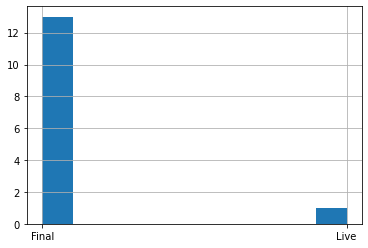

In [56]:
df['status.abstractGameState'].hist()

In [62]:
game_pk = 642217

In [67]:
import json
# load data using Python JSON module
with urllib.request.urlopen("http://statsapi.mlb.com/api/v1.1/game/" + str(game_pk) + "/feed/live") as url:
    data = json.loads(url.read())
    
# pull features from API/payload data - live data
plays   = pd.json_normalize(data, record_path =['liveData', 'plays', 'allPlays', 'playEvents']) # Bill had ' %>% bind_rows()' here. WHY?
at_bats = pd.json_normalize(data, record_path =['liveData', 'plays', 'allPlays'])
current = pd.json_normalize(data, record_path =['liveData', 'plays', 'currentPlay'])

# pull feature from API/payload data - game metadata
game_status   = pd.json_normalize(data, record_path =['gameData', 'status', 'abstractGameState'])

#TODO NIC --> Keep converting these below to the Pythonic format. Then begin tackling converting the rest of Bill's function to Python
home_team     <- payload$gameData$teams$home$name
home_level    <- payload$gameData$teams$home$sport
home_league   <- payload$gameData$teams$home$league
away_team     <- payload$gameData$teams$away$name
away_level    <- payload$gameData$teams$away$sport
away_league   <- payload$gameData$teams$away$league

,index,startTime,endTime,isPitch,type,details.description,details.event,details.eventType,details.awayScore,details.homeScore,...,hitData.coordinates.coordX,hitData.coordinates.coordY,actionPlayId,isBaseRunningPlay,details.fromCatcher,isSubstitution,position.code,position.name,position.type,position.abbreviation
0,0,2021-03-28T23:10:50.585Z,2021-03-29T00:52:51.583Z,False,action,Status Change - Pre-Game,Game Advisory,game_advisory,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2021-03-29T00:52:51.583Z,2021-03-29T01:07:01.201Z,False,action,Status Change - Warmup,Game Advisory,game_advisory,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2021-03-29T01:07:01.201Z,2021-03-29T01:08:07.172Z,False,action,Status Change - In Progress,Game Advisory,game_advisory,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2021-03-29T01:08:07.172Z,2021-03-29T01:08:19.111Z,True,pitch,Called Strike,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2021-03-29T01:08:19.111Z,2021-03-29T01:08:32.826Z,True,pitch,Ball,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:

    
    # need to look into what this is doing
    list_columns  <- lapply(at_bats, function(x) class(x)) %>% 
      dplyr::bind_rows(.id = "variable") %>% tidyr::gather(key, 
                                                           value) %>% dplyr::filter(value == "list") %>% dplyr::pull(key)
    
    at_bats <- at_bats %>% dplyr::select(-c(one_of(list_columns)))
    
    # building pitch by pitch data
    
    pbp <- plays %>% dplyr::left_join(at_bats, by = c(endTime = "playEndTime"))
    
    # Fill missing values - why is this separate from mutates below? Assess run time differences
    pbp <- pbp %>% tidyr::fill(atBatIndex:matchup.splits.menOnBase, 
                               .direction = "up") %>% 
      dplyr::mutate(game_pk = game_pk, 
                    game_date = substr(payload$gameData$datetime$dateTime, 1, 10)) %>% 
      dplyr::select(game_pk, game_date, everything())
    
    # Fill columns of data frame with values pulled in code above
    pbp <- pbp %>% dplyr::mutate(matchup.batter.fullName  = factor(matchup.batter.fullName), 
                                 matchup.pitcher.fullName = factor(matchup.pitcher.fullName), 
                                 atBatIndex               = factor(atBatIndex)) %>% 
      dplyr::mutate(home_team                = home_team, 
                    home_level_id            = home_level$id, 
                    home_level_name          = home_level$name, 
                    #home_parentOrg_id        = payload$gameData$teams$home$parentOrgId, 
                    #home_parentOrg_name      = payload$gameData$teams$home$parentOrgName, 
                    home_league_id           = home_league$id, 
                    home_league_name         = home_league$name, 
                    away_team                = away_team, 
                    away_level_id            = away_level$id, 
                    away_level_name          = away_level$name, 
                    #away_parentOrg_id        = payload$gameData$teams$away$parentOrgId, 
                    #away_parentOrg_name      = payload$gameData$teams$away$parentOrgName, 
                    away_league_id           = away_league$id, 
                    away_league_name         = away_league$name, 
                    batting_team             = factor(ifelse(about.halfInning == "bottom", home_team, away_team)), 
                    fielding_team            = factor(ifelse(about.halfInning == "bottom", away_team, home_team)))
    
    pbp <- pbp %>% dplyr::arrange(desc(atBatIndex), desc(pitchNumber))
    pbp <- pbp %>% dplyr::group_by(atBatIndex) %>% 
      dplyr::mutate(last.pitch.of.ab = ifelse(pitchNumber == max(pitchNumber), "true", "false"), 
                    last.pitch.of.ab = factor(last.pitch.of.ab)) %>% 
      ungroup()
    
    pbp <- dplyr::bind_rows(stats_api_live_empty_df, pbp)
    
    check_home_level <- pbp %>% dplyr::distinct(home_level_id) %>% dplyr::pull()
    
    pbp <- pbp %>% dplyr::rename(count.balls.start   = count.balls.x, 
                                 count.strikes.start = count.strikes.x, count.outs.start = count.outs.x, 
                                 count.balls.end     = count.balls.y, count.strikes.end = count.strikes.y, 
                                 count.outs.end      = count.outs.y)
    return(pbp)
  }